In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import helper

In [7]:
data_path = "../wavelets/kth-tips2-b_col_200x200/"
transform = transforms.Compose([transforms.Resize(255), 
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])
dataset = datasets.ImageFolder(data_path, transform=transform)

In [8]:
# DataLoaders
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                         shuffle=True)

In [9]:
images, labels = next(iter(dataloader))

In [10]:
# Source https://stackoverflow.com/questions/53570181/error-in-importing-libraries-of-helper-though-helper-is-installed
import numpy as np
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

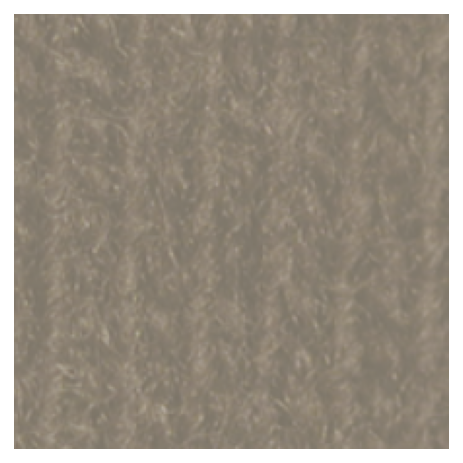

In [11]:
imshow(images[0].view(3, 224, 224));

## Concatenating pytorch tensors

There are functions that can do the concatenation in Pytorch (e.g. `torch.cat` or `torch.stack`). But before considering channelwise concatenation, it might be better to start with the wavelet transform of the function and the projection shortcut.

In [12]:
x = torch.randn(3, 224, 224)

In [13]:
m = 224//2
x1 = x[:, :m, :m]
x2 = x[:, m:, m:]

In [14]:
x.ravel().shape

torch.Size([150528])

In [15]:
x3 = torch.cat([x1, x2], 1)

In [16]:
x4 = torch.cat([x1, x2], 2)

In [17]:
x3.shape

torch.Size([3, 224, 112])

In [18]:
torch.cat([x3, x2], 2)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 224 but got size 112 for tensor number 1 in the list.

In [19]:
x.ravel().reshape(3, 224, 224).shape

torch.Size([3, 224, 224])

# Decomposing data with Haar wavelet using pywt

In [20]:
x = images[0].numpy()

In [21]:
x.shape

(3, 224, 224)

In [22]:
import pywt
# compute the 2D DWT
c1 = pywt.wavedec2(x, 'Haar', mode='periodization', level=1)
c2 = pywt.wavedec2(x, 'Haar', mode='periodization', level=2)
c3 = pywt.wavedec2(x, 'Haar', mode='periodization', level=3)
c4 = pywt.wavedec2(x, 'Haar', mode='periodization', level=4)

In [23]:
arr1, slices1 = pywt.coeffs_to_array(c1, axes=[1, 2])
arr2, slices2 = pywt.coeffs_to_array(c2, axes=[1, 2])
arr3, slices3 = pywt.coeffs_to_array(c3, axes=[1, 2])
arr4, slices4 = pywt.coeffs_to_array(c4, axes=[1, 2])

In [44]:
def decomposition(img, level):
    
    c = pywt.wavedec2(x, 'Haar', mode='periodization', level=level)
    arr, slices = pywt.coeffs_to_array(c, axes=[1, 2])
    return arr, slices

decomposition_dict = {"level"+str(l+1): decomposition(x, l+1) for l in range(4)}

In [56]:
decomposition_dict["level3"][0]

array([[[ 2.70098019e+00,  2.30245066e+00,  2.06666636e+00, ...,
         -5.09803891e-02,  1.11764729e-01,  6.07843250e-02],
        [ 1.83382344e+00,  2.82205868e+00,  2.11274481e+00, ...,
         -6.07843250e-02,  6.27451241e-02,  3.52941453e-02],
        [ 1.91813719e+00,  1.45098031e+00,  2.59558797e+00, ...,
         -5.29411733e-02,  3.13725173e-02, -5.29411435e-02],
        ...,
        [-7.84312747e-03,  1.56862568e-02,  2.15686187e-02, ...,
         -1.96077675e-03,  1.96077675e-03, -1.96078722e-03],
        [ 6.27451092e-02,  1.56862766e-01, -5.88235334e-02, ...,
         -1.76470540e-02,  2.94117574e-02,  1.76470540e-02],
        [ 1.96078606e-03,  5.68627492e-02,  7.84313865e-03, ...,
         -1.56862698e-02,  1.37254875e-02,  3.92158516e-03]],

       [[ 2.18333316e+00,  2.01176453e+00,  1.75294113e+00, ...,
         -5.68627715e-02,  1.11764669e-01,  4.90196049e-02],
        [ 1.58676445e+00,  2.38970566e+00,  1.81176460e+00, ...,
         -5.88235110e-02,  6.66666627e

In [49]:
pywt.downcoef('d', x, "Haar", mode='periodization', level=1)

ValueError: downcoef only supports 1d data.

In [95]:
slices2

[(slice(None, 3, None), slice(None, 56, None), slice(None, 56, None)),
 {'ad': (slice(None, None, None), slice(None, 56, None), slice(56, 112, None)),
  'da': (slice(None, None, None), slice(56, 112, None), slice(None, 56, None)),
  'dd': (slice(None, None, None), slice(56, 112, None), slice(56, 112, None))},
 {'ad': (slice(None, None, None),
   slice(None, 112, None),
   slice(112, 224, None)),
  'da': (slice(None, None, None),
   slice(112, 224, None),
   slice(None, 112, None)),
  'dd': (slice(None, None, None),
   slice(112, 224, None),
   slice(112, 224, None))}]

In [85]:
arr1[slices1[1]["dd"]].shape

(3, 112, 112)

In [90]:
c4[0].shape

(3, 14, 14)

In [93]:
arr4

array([[[ 1.0330146e+01,  1.0488726e+01,  9.7215672e+00, ...,
          3.3333361e-02,  1.3725519e-02, -1.9607842e-01],
        [ 9.7549009e+00,  1.0668136e+01,  1.0092891e+01, ...,
          3.7254900e-02,  0.0000000e+00, -2.2352946e-01],
        [ 9.8475475e+00,  1.1057352e+01,  1.0342891e+01, ...,
          4.1176468e-02, -9.8039210e-02, -1.3725495e-01],
        ...,
        [-3.5294108e-02, -3.9215535e-03, -6.2745109e-02, ...,
          1.5686277e-02,  2.3529403e-02,  1.9607991e-03],
        [-5.8823533e-02, -1.1764702e-02, -3.5294127e-02, ...,
         -4.3137237e-02,  7.4509814e-02, -3.1372555e-02],
        [-5.0980404e-02, -2.1568628e-02, -7.8431489e-03, ...,
         -5.8823526e-03, -9.8039256e-03,  7.8431489e-03]],

       [[ 6.5651951e+00,  6.6678915e+00,  5.9267149e+00, ...,
          2.9411748e-02,  1.3725519e-02, -2.5098035e-01],
        [ 5.9416656e+00,  6.7710781e+00,  6.2796564e+00, ...,
          4.5098037e-02,  0.0000000e+00, -2.9019609e-01],
        [ 6.0107841e+00, 

In [46]:
x.T.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


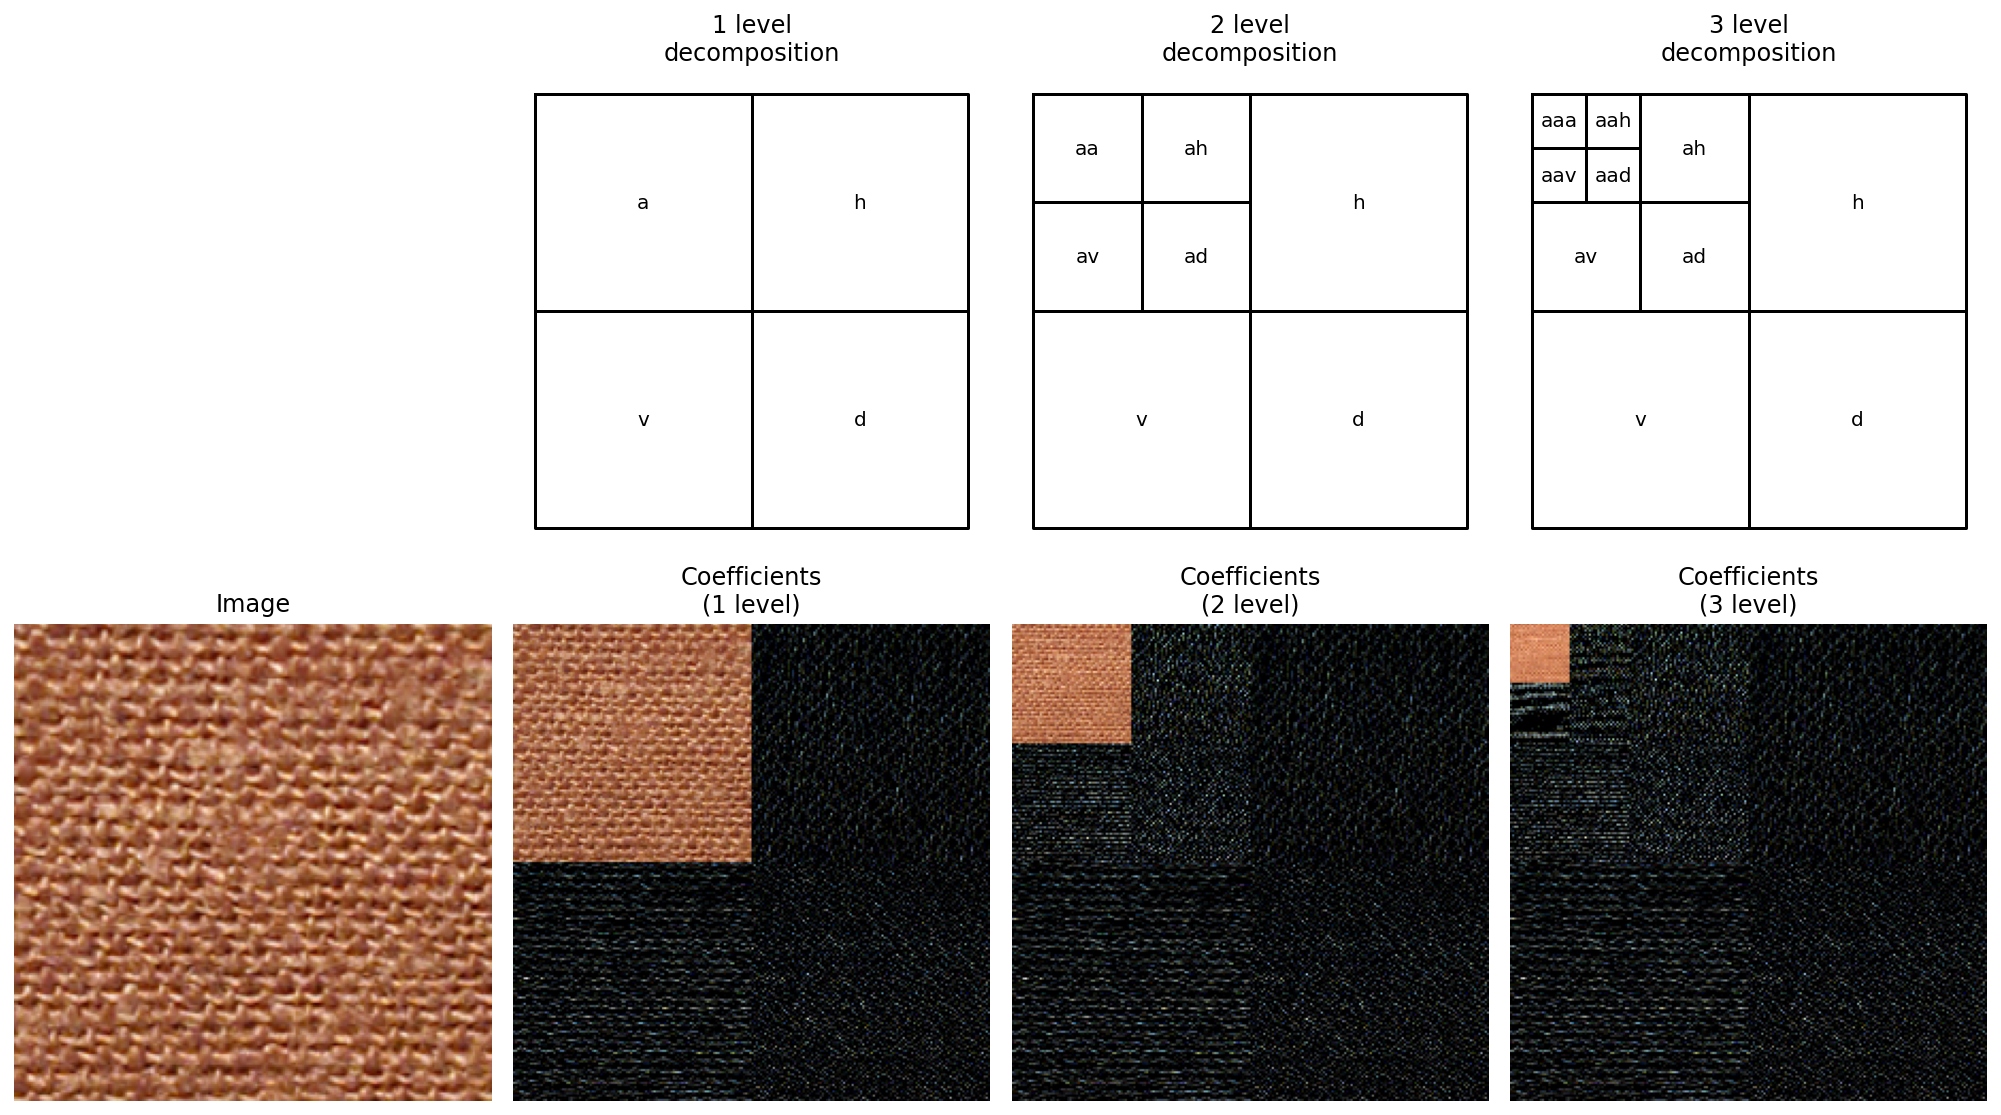

In [42]:
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

shape = x.T.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x.T, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'Haar', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c, axes=[1, 2])
    print(arr.shape)
    axes[1, level].imshow(arr.T, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()
